#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [6]:
df = prepare_dataframe().copy()

In [7]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [8]:
df = add_additional_boxes(df)

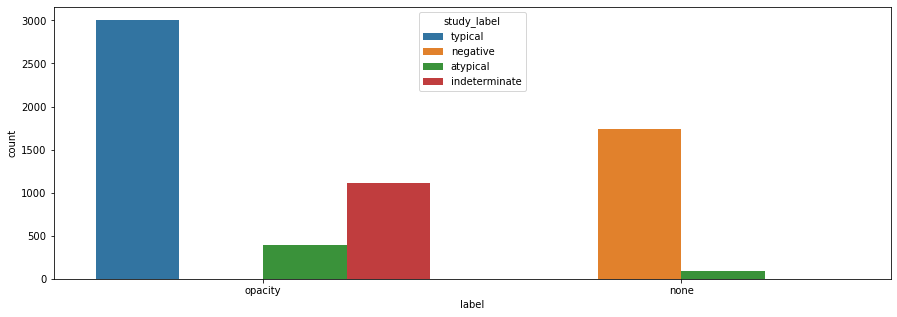

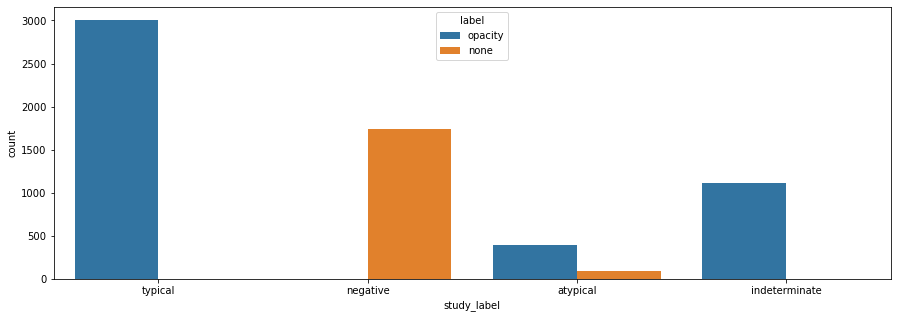

In [9]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

In [10]:
df['target_bin'] = df['study_label'] == "indeterminate"

In [11]:
Counter(df['target_bin'])

Counter({False: 5225, True: 1108})

### PL

In [12]:
df_test = pd.read_csv('../input/df_test_512.csv')

In [13]:
df_test['shape'] = df_test['shape'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))
df_test['shape_crop'] = df_test['shape_crop'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))
df_test['crop_starts'] = df_test['crop_starts'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))

In [14]:
pl_study = pd.read_csv('../output/sub_0931_study.csv')
pl_study["study_id"] = pl_study["id"].apply(lambda x: x.split('_')[0])
pl_study.drop(['id', 'PredictionString'], axis=1, inplace=True)

In [15]:
pl_img = pd.read_csv('../output/sub_0931_img.csv')
pl_img["image_id"] = pl_img["id"].apply(lambda x: x.split('_')[0])
pl_img.drop(['id', 'PredictionString'], axis=1, inplace=True)

In [16]:
df_test = df_test.merge(pl_study, how="left", on="study_id")
df_test = df_test.merge(pl_img, how="left", on="image_id")

In [17]:
df['is_pl'] = 0
df_test['is_pl'] = 1

df['root'] = DATA_PATH + f"train_{SIZE}/"
df_test['root'] = DATA_PATH + f"test_{SIZE}/"

In [18]:
df_test['kfold'] = -1
df_test['img_target'] = 1 - df_test['none']

### Dataset

In [19]:
df_ = df[df['crop_starts'].apply(lambda x: np.max(x) > 100)].reset_index()

In [20]:
transforms = get_transfos_det(augment=True, bbox_format="yolo")

In [21]:
dataset = CovidDetDataset(df_, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

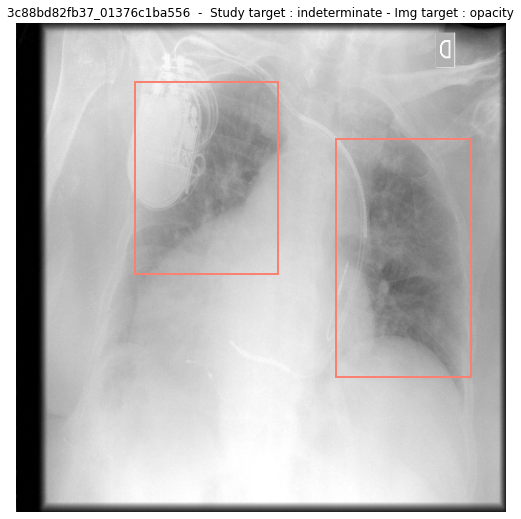

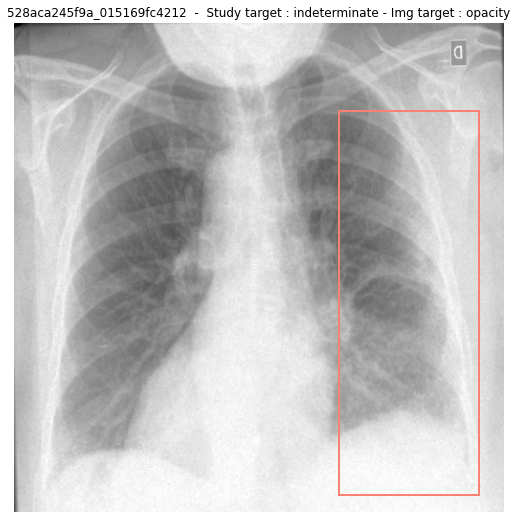

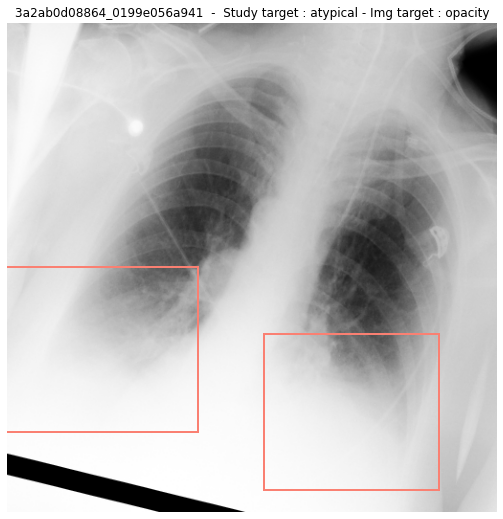

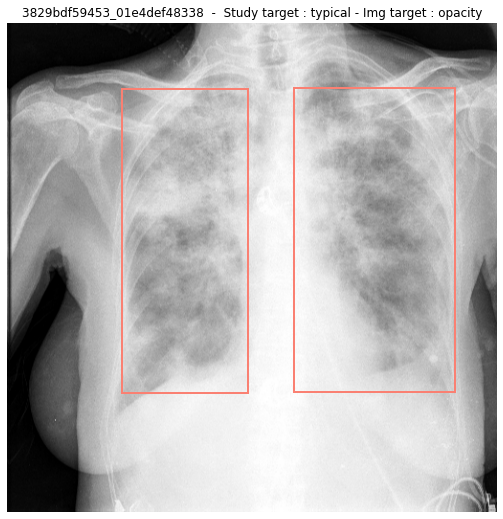

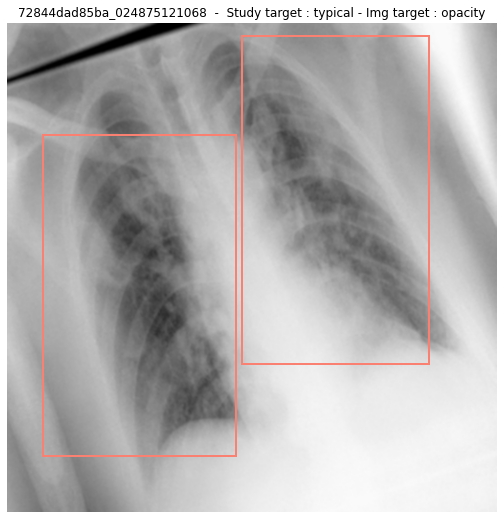

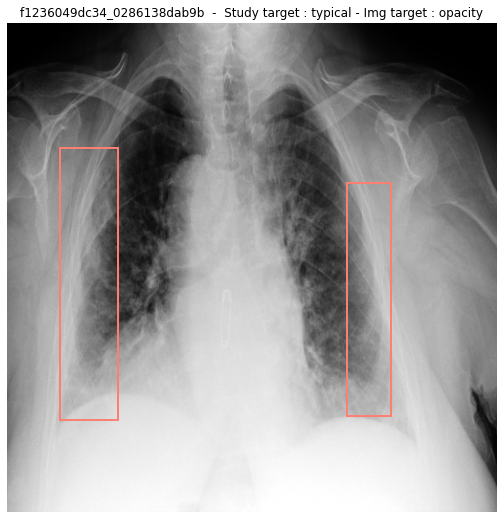

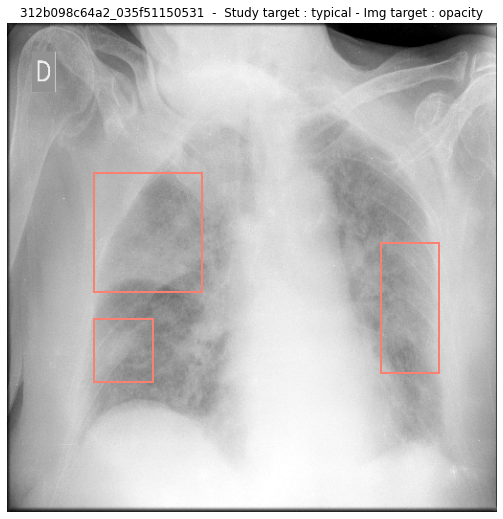

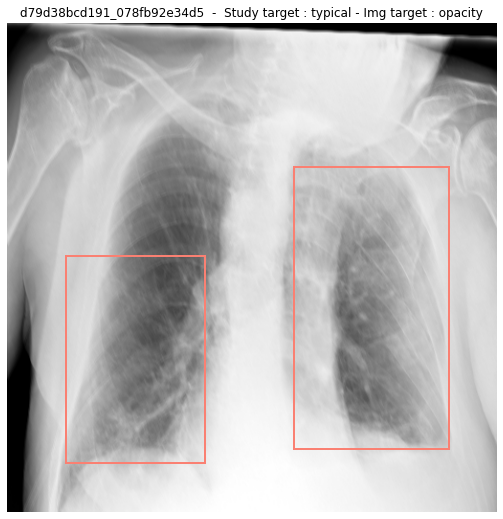

In [22]:
# for i in np.random.choice(len(dataset), 10):
for i in range(10):
    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if len(boxes):
        plt.figure(figsize=(9, 9))
        plot_sample(img, boxes, bbox_format="yolo")
        plt.title(
            f'{df_["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
            f'Img target : {CLASSES_IMG[int(y_img)]}'
        )
        plt.show()

## Model

In [23]:
# import timm

# class Covid_Net(nn.Module):
#     def __init__(self,model_name,pretrained,out_features):
#         super(Covid_Net, self).__init__()
#         self.net = timm.create_model(model_name,pretrained=pretrained)
        
#         in_features = self.net.classifier.in_features
#         self.net.global_pool = nn.Identity()
#         self.net.classifier = nn.Identity()
        
#         self.logit = nn.Linear(in_features,out_features)
        
#     def forward(self, image):
#         #b,c,h,w
#         batch_size = len(image)
#         x = self.net(image)
#         x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
#         logit = self.logit(x)
        
#         return logit
    
# model_params = {
#     'model_name':'tf_efficientnetv2_m_in21ft1k',
#     'pretrained':True,
#     'out_features':1
# }

# model = Covid_Net(**model_params)


# torch.save(model.net.state_dict(), "../output/pretrained_tf_efficientnetv2_m_in21ft1k")

In [24]:
# model = get_encoder('tf_efficientnet_b4_ns')

In [25]:
model = get_model('tf_efficientnetv2_m_in21ft1k', num_classes=1)

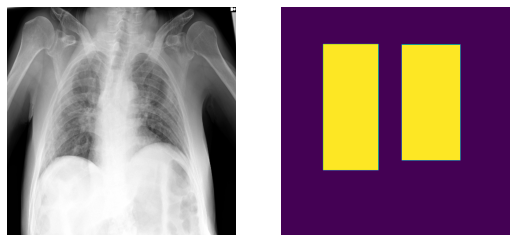

In [26]:
transforms = get_transfos_cls(augment=False)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img, _ = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [27]:
model.encoder.nb_fts

[48, 80, 176, 512]

In [28]:
pred = model(x)

In [29]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

torch.Size([1, 1])
torch.Size([1, 1])
  torch.Size([1, 1, 32, 32])
  torch.Size([1, 1, 16, 16])


In [30]:
from training.losses import *

In [31]:
loss_config = {  
    "w_bce": 0.75,
    "w_seg_loss": 0.95,
    "seg_loss_multiplier": 4,
    "w_study": 2,
    "w_img": 1,
}

loss = CovidLoss(loss_config)

In [32]:
loss(pred[0], pred[1], pred[2], y, y_img, m, torch.zeros(1).unsqueeze(0))

tensor([[2.4367]], grad_fn=<AddBackward0>)

In [33]:
# loss(pred[0], y), loss(pred[0], torch.tensor([[0, 1, 0, 0]]).long()), nn.CrossEntropyLoss(reduction="none")(pred[0], y.long())

### Training

In [34]:
BATCH_SIZES = {
    "resnext50_32x4d": 16,
    'tf_efficientnetv2_s_in21ft1k': 8, # 16
    'tf_efficientnetv2_m_in21ft1k': 12, #6
    'tf_efficientnetv2_l_in21ft1k': 6,
    'tf_efficientnet_b2_ns': 12,
    'tf_efficientnet_b3_ns': 16,
    'tf_efficientnet_b4_ns': 12,
    'tf_efficientnet_b5_ns': 8,
}

In [35]:
USE_PL = False

In [36]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1

    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'tf_efficientnetv2_m_in21ft1k'
    use_unet = False
    pretrained = False
    num_classes = 1

    # Training
    loss_config = {  
        "w_bce": 0.75,
        "w_seg_loss": 0.95 if "v2_s" in selected_model else 0.75,
        "seg_loss_multiplier": 4 if "v2_s" in selected_model else 2,
        "w_study": 2,
        "w_img": 0.1,
    }
    use_fp16 = False if "v2_s" in selected_model else True
    samples_per_patient = 1
    optimizer = ["Adam", "RAdam_lookahead", "RAdam"]
    batch_size = BATCH_SIZES[selected_model]
    epochs = [8 if USE_PL else 10] #, 5, 5]

    lr = [1e-3, 1e-4, 1e-5]
    warmup_prop = [0.05, 0.25, 0.5]
    val_bs = batch_size * 2

    first_epoch_eval = 0

    mix = "cutmix"
    mix_proba = 0 if USE_PL else 0.5
    mix_alpha = 0.4

    name = "model"

In [37]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")

pred_oof_study, pred_oof_img = k_fold(
    Config,
    df,
    df_extra=df_test if USE_PL else None,
    log_folder=log_folder
)

Logging results to ../logs/2021-08-04/4/

-------------   Fold 1 / 5  -------------

    -> 5064 training images
    -> 1269 validation images
    -> 55229664 trainable parameters

 - Training 1 / 1 : 	epochs: 10	lr: 1.0e-03	warmup_prop: 0.05	optimizer: Adam
Using 403 out of 422 batches by limiting to 1 samples per study.

Epoch 01/10 	 lr=9.5e-04	 t=163s 	loss=0.806	val_loss=0.614	study_map=0.212	img_auc=0.880
Epoch 02/10 	 lr=8.4e-04	 t=164s 	loss=0.628	val_loss=0.601	study_map=0.211	img_auc=0.882
Epoch 03/10 	 lr=7.4e-04	 t=165s 	loss=0.610	val_loss=0.615	study_map=0.224	img_auc=0.891
Epoch 04/10 	 lr=6.3e-04	 t=165s 	loss=0.594	val_loss=0.563	study_map=0.239	img_auc=0.885
Epoch 05/10 	 lr=5.3e-04	 t=166s 	loss=0.589	val_loss=0.579	study_map=0.213	img_auc=0.893
Epoch 06/10 	 lr=4.2e-04	 t=166s 	loss=0.583	val_loss=0.557	study_map=0.240	img_auc=0.899
Epoch 07/10 	 lr=3.2e-04	 t=166s 	loss=0.571	val_loss=0.542	study_map=0.243	img_auc=0.898
Epoch 08/10 	 lr=2.1e-04	 t=165s 	loss=0.555	